# Grocery Recommendation Project

1. Data Clustering on users  
2. Recommendation systems
  * Content-based filtering  
  * Collaborative filtering  
3. Market Basket analysis  
4. Website interface  

For this analysis I will be working as a Data Scientist for a grocery store that is looking to discover insights from sales data that could be used for targeted direct mail marketing (specific coupons mailed to customers), targeted email marketing ("An item you like has gone on sale!"), and online shopper recommendations to 'add to cart' based on similar items and also based on items other people who bought that item have purchased.  

If time permits, I may also perform a market basket analysis to forecast what products a customer is likely to purchase in their next order.

## Dataset information

This data was retrieved from Kaggle and was provided by Instacart for a market basket analysis competition in 2018.  

The data is divided into 6 files:

- **_Aisles.csv_**: 134 Unique aisle numbers and descriptions
- **_Departments.csv_**: 21 Unique department numbers and descriptions
- **_Products.csv_**: 49,688 Unique product ids, with description, aisle id, and department id
- **_Orders.csv_**: 3,421,083 Unique order id, with user id, order number, order_dow, order_hour_of_day, days_since_prior_order, and eval_set indicating if the order is in train, prior, or test
- **_Order_products_train.csv_**: Order id, product id, add to cart order, and reorder indicator
- **_Order_products_prior.csv_**: Order id, product id, add to cart order, and reorder indicator


Some ideas for exploration:

1. Look at ROI for each zip code, over the whole dataset, avg for each year, 3 year avg, 5 year avg, 10 year avg
2. Plot median sales price against ROI to get quadrants for comparison
3. Which zips have highest and lowest ROI?
4. Business case - choose highest ROI for small investors

## Data Preprocessing

### Import and basic info

**Output** - aisles, orders, products, departments, order_products_prior, order_products_train

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from user_functions import *
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set default visualization parameters

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber, CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
sns.set_context("notebook", rc={"font.size":16, "axes.titlesize":20, "axes.labelsize":18})
sns.set(font='Franklin Gothic Book',
rc={'axes.axisbelow': False,
'axes.edgecolor': 'lightgrey',
# 'axes.edgecolor': 'white',
'axes.facecolor': 'None',
'axes.grid': False,
'axes.labelcolor': 'dimgrey',
# 'axes.labelcolor': 'white',
'axes.spines.right': False,
'axes.spines.top': False,
'axes.prop_cycle': plt.cycler(color=color_list),
'figure.facecolor': 'white',
'lines.solid_capstyle': 'round',
'patch.edgecolor': 'w',
'patch.force_edgecolor': True,
'text.color': 'dimgrey',
# 'text.color': 'white',    
'xtick.bottom': False,
'xtick.color': 'dimgrey',
# 'xtick.color': 'white',    
'xtick.direction': 'out',
'xtick.top': False,
'ytick.color': 'dimgrey',
# 'ytick.color': 'white',
'ytick.direction': 'out',
'ytick.left': False,
'ytick.right': False})
%matplotlib inline

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [3]:
aisles = pd.read_csv("Data/aisles.csv")
departments = pd.read_csv("Data/departments.csv")
order_products_prior = pd.read_csv("Data/order_products__prior.csv")
order_products_train = pd.read_csv("Data/order_products__train.csv")
orders = pd.read_csv("Data/orders.csv")
products = pd.read_csv("Data/products.csv")

In [4]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


### Checking for Nan values

Data is very clean. Nan values in orders.days_since_prior_order, but they are valid.

In [5]:
aisles.isna().sum()

aisle_id    0
aisle       0
dtype: int64

In [6]:
departments.isna().sum()

department_id    0
department       0
dtype: int64

In [7]:
products.isna().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [8]:
orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [9]:
orders.days_since_prior_order.value_counts()
# Nothing greater than 30 here so it must actually be '30+'

30.0    369323
7.0     320608
6.0     240013
4.0     221696
3.0     217005
5.0     214503
2.0     193206
8.0     181717
1.0     145247
9.0     118188
14.0    100230
10.0     95186
13.0     83214
11.0     80970
12.0     76146
0.0      67755
15.0     66579
16.0     46941
21.0     45470
17.0     39245
20.0     38527
18.0     35881
19.0     34384
22.0     32012
28.0     26777
23.0     23885
27.0     22013
24.0     20712
25.0     19234
29.0     19191
26.0     19016
Name: days_since_prior_order, dtype: int64

In [10]:
orders.head()
# order_id is a unique key for the order
# order_number is specific to a user
# seems like for any user, order 1 will have a Nan in days_since_prior_order since it is their first order

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [11]:
order_products_train.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [12]:
order_products_prior.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

### Analyze 'Products'
  
49688 unique products 

In [13]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [14]:
print(len(products))
print(products.aisle_id.nunique())
print(products.department_id.nunique())

49688
134
21


In [15]:
# How many products in each department and aisle?
# I guess these would be better/more informative with aisle and dept names
products_aisles = pd.merge(products, aisles, on = 'aisle_id', how = 'left')
products_desc = pd.merge(products_aisles, departments, on = 'department_id', how = 'left')
products_desc.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


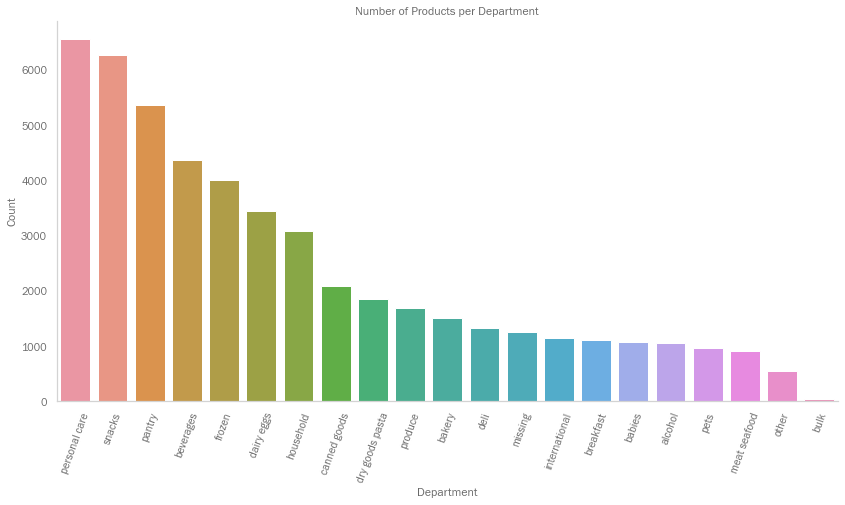

In [16]:
plt.figure(figsize = (14,7))
sns.countplot(x='department', data= products_desc, order = products_desc.department.value_counts().index)
plt.title('Number of Products per Department')
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Department')
plt.savefig('Images/products_by_department.png');

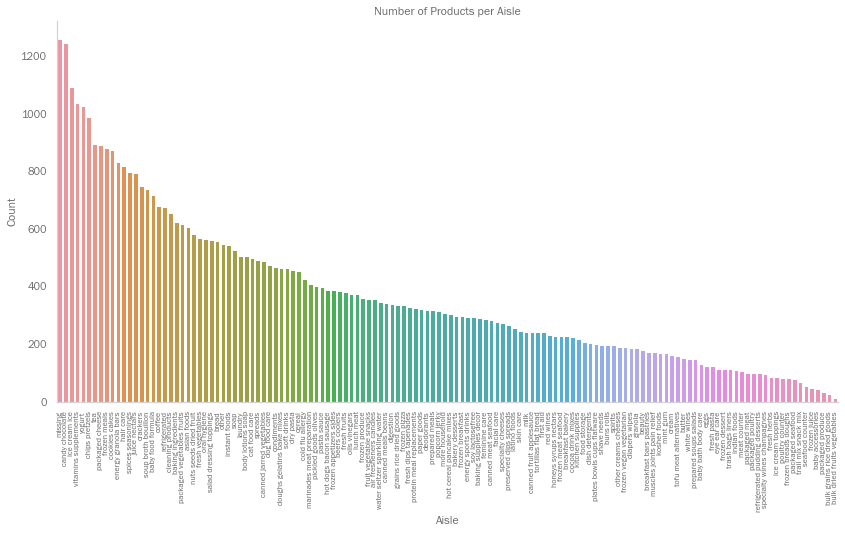

In [17]:
plt.figure(figsize = (14,7))
sns.countplot(x='aisle', data= products_desc, order = products_desc.aisle.value_counts().index)
plt.title('Number of Products per Aisle')
plt.xticks(rotation=90, fontsize = 8)
plt.ylabel('Count')
plt.xlabel('Aisle')
plt.savefig('Images/products_by_aisle.png');
# Uh oh, 'missing' is our most popular aisle
# And I see there is a 'missing' value for department above as well

In [18]:
products_desc[products_desc['aisle']=='missing']
# It appears that 1258 products have 'missing' aisle 100 and department 21

,product_id,product_name,aisle_id,department_id,aisle,department
37,38,Ultra Antibacterial Dish Liquid,100,21,missing,missing
71,72,Organic Honeycrisp Apples,100,21,missing,missing
109,110,Uncured Turkey Bologna,100,21,missing,missing
296,297,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",100,21,missing,missing
416,417,Classics Baby Binks Easter Chocolate Bunny,100,21,missing,missing
...,...,...,...,...,...,...
49552,49553,Organic Plain Skyr,100,21,missing,missing
49574,49575,Chocolate Vanilla Malt Custard,100,21,missing,missing
49640,49641,"8\"" Pecan Pie",100,21,missing,missing
49663,49664,Lemon Cayenne Drinking Vinegar,100,21,missing,missing


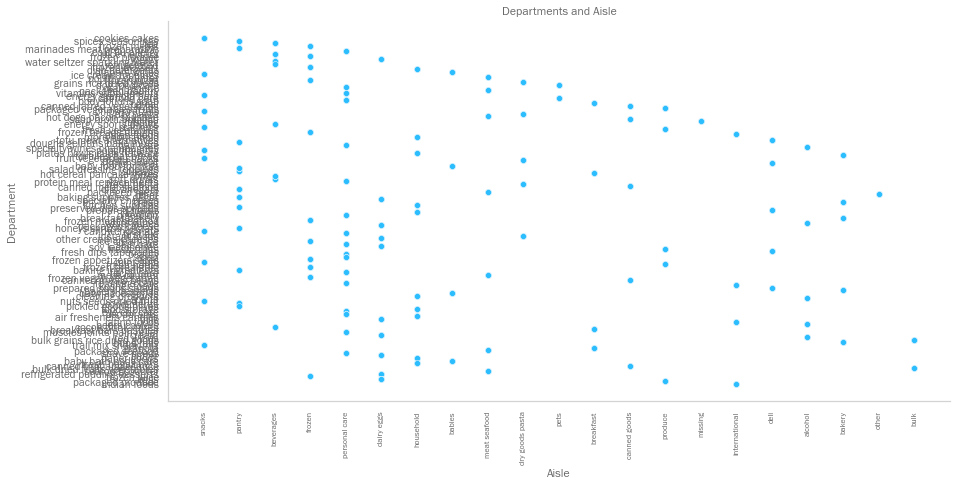

In [19]:
plt.figure(figsize = (14,7))
sns.scatterplot(y='aisle', x='department', data= products_desc)
plt.title('Departments and Aisle')
plt.xticks(rotation=90, fontsize = 8)
plt.ylabel('Department')
plt.xlabel('Aisle')
plt.savefig('Images/depts_by_aisle.png');

In [20]:
# Just confirming the one to many relationship between department and aisle
products_desc[products_desc['department']=='snacks']

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
15,16,Mint Chocolate Flavored Syrup,103,19,ice cream toppings,snacks
24,25,Salted Caramel Lean Protein & Fiber Bar,3,19,energy granola bars,snacks
31,32,Nacho Cheese White Bean Chips,107,19,chips pretzels,snacks
40,41,Organic Sourdough Einkorn Crackers Rosemary,78,19,crackers,snacks
...,...,...,...,...,...,...
49661,49662,Bacon Cheddar Pretzel Pieces,107,19,chips pretzels,snacks
49664,49665,Super Dark Coconut Ash & Banana Chocolate Bar,45,19,candy chocolate,snacks
49665,49666,Ginger Snaps Snacking Cookies,61,19,cookies cakes,snacks
49670,49671,Milk Chocolate Drops,45,19,candy chocolate,snacks


In [21]:
# An aisle only belongs to one department
products_desc[products_desc['aisle_id']==45]

,product_id,product_name,aisle_id,department_id,aisle,department
123,124,Sun Cups Dark Chocolate,45,19,candy chocolate,snacks
135,136,Simple,45,19,candy chocolate,snacks
183,184,Kisses Milk Chocolate Candy,45,19,candy chocolate,snacks
206,207,Minis Candy Bars,45,19,candy chocolate,snacks
226,227,Triple Chocolate Snack Size,45,19,candy chocolate,snacks
...,...,...,...,...,...,...
49503,49504,Dark Chocolate Peanut Butter Cups Miniatures,45,19,candy chocolate,snacks
49600,49601,Pomegranate Gummy Bears,45,19,candy chocolate,snacks
49619,49620,Milk Chocolate Mini's,45,19,candy chocolate,snacks
49664,49665,Super Dark Coconut Ash & Banana Chocolate Bar,45,19,candy chocolate,snacks


### Analyze Orders

In [22]:
print(len(orders))
print(orders.order_id.min())
print(orders.order_id.max())

3421083
1
3421083


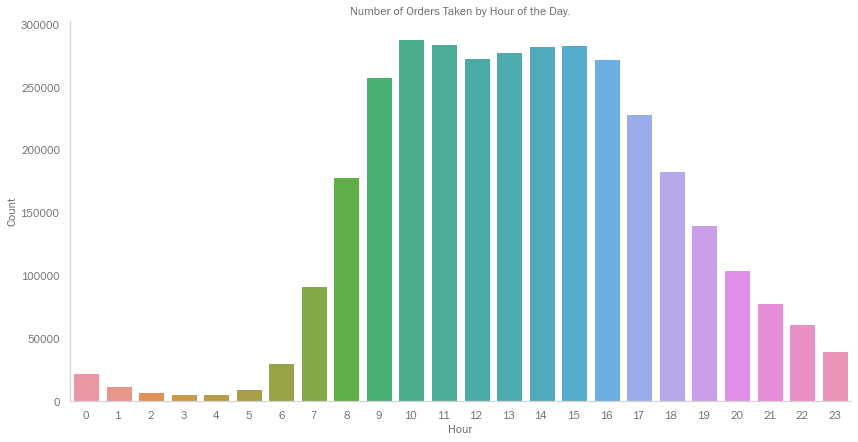

In [23]:
plt.figure(figsize = (14,7))
sns.countplot(x='order_hour_of_day', data= orders)
plt.title('Number of Orders Taken by Hour of the Day.')
plt.ylabel('Count')
plt.xlabel('Hour')
plt.savefig('Images/orders_by_hour.png');

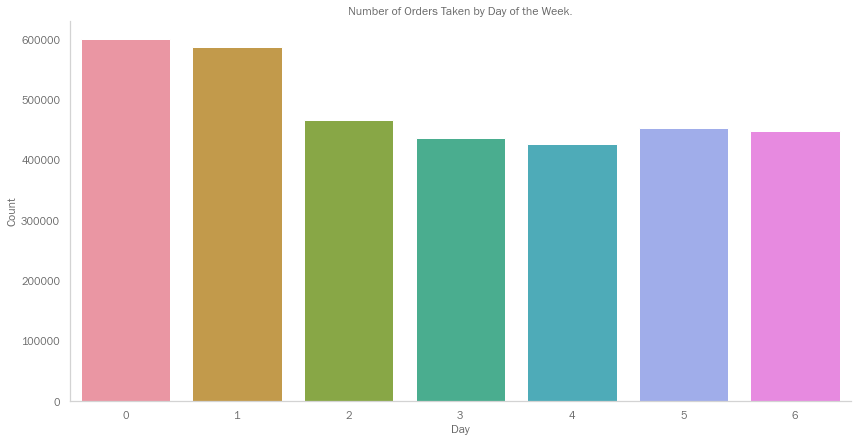

In [24]:
plt.figure(figsize = (14,7))
sns.countplot(x='order_dow', data= orders)
plt.title('Number of Orders Taken by Day of the Week.')
plt.ylabel('Count')
plt.xlabel('Day')
plt.savefig('Images/orders_by_dow.png');

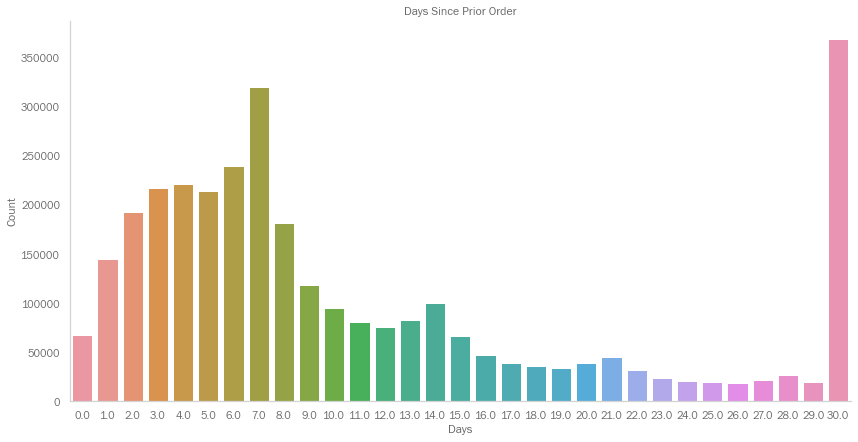

In [25]:
plt.figure(figsize = (14,7))
sns.countplot(x='days_since_prior_order', data= orders)
plt.title('Days Since Prior Order')
plt.ylabel('Count')
plt.xlabel('Days')
plt.savefig('Images/days_since_order.png');

# Spikes at 7, 14, 21, and 28 indicate people who reorder weekly, or every 2 or three weeks but on the same day
# Does 0.0 days mean someone ordered twice in the same day?
# Surprising how many people order more than once a week
# 30 does seem to indicate 30 or more days since last order

In [26]:
orders.head(15)
# Appears to be sorted by user_id and then order_number
# Most recent order_number per user_id is in the train(or test) set, others in prior
# First order per user has NaN in days_since

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [27]:
orders.sort_values('order_id') # Just checking that it has all the order_ids starting at 1

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1868044,1,112108,train,4,4,10,9.0
3355525,2,202279,prior,3,5,9,8.0
3417191,3,205970,prior,16,5,17,12.0
2958007,4,178520,prior,36,1,9,7.0
2593373,5,156122,prior,42,6,16,9.0
...,...,...,...,...,...,...,...
1809968,3421079,108687,prior,6,1,13,0.0
877324,3421080,52726,prior,2,1,11,2.0
1949724,3421081,117076,prior,1,3,11,NaN
2903252,3421082,175185,prior,23,2,18,4.0


In [28]:
orders_test = orders[orders['eval_set']=='test'] # 75000 orders in our test set
# So basically for these test orders, I don't have the answers.  I don't know what products were ordered.
orders_test

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0
...,...,...,...,...,...,...,...
3420918,2728930,206202,test,23,2,17,6.0
3420929,350108,206204,test,5,4,14,14.0
3421001,1043943,206206,test,68,0,20,0.0
3421018,2821651,206207,test,17,2,13,14.0


In [29]:
orders[orders['user_id']==3] # But I have all of this user's order/products in prior

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
26,1374495,3,prior,1,1,14,NaN
27,444309,3,prior,2,3,19,9.0
28,3002854,3,prior,3,3,16,21.0
29,2037211,3,prior,4,2,18,20.0
30,2710558,3,prior,5,0,17,12.0
31,1972919,3,prior,6,0,16,7.0
32,1839752,3,prior,7,0,15,7.0
33,3225766,3,prior,8,0,17,7.0
34,3160850,3,prior,9,0,16,7.0
35,676467,3,prior,10,3,16,17.0


### Analyze Order_products_train and _prior

In [30]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [31]:
print(len(order_products_train)) # Has 1,384,617 order/products
print(order_products_train.order_id.min()) # starts with order number 1
print(order_products_train.order_id.max())
print(order_products_train.order_id.nunique()) # Has 131,209 unique orders

1384617
1
3421070
131209


In [32]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [33]:
print(len(order_products_prior)) # Has 32,434,489 order/products
print(order_products_prior.order_id.min()) # starts with order number 2
print(order_products_prior.order_id.max())
print(order_products_prior.order_id.nunique()) # Has 3,214,874 unique orders

32434489
2
3421083
3214874


In [34]:
order_products_prior[order_products_prior.order_id == 2]

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0


In [35]:
orders[orders.order_id == 2]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3355525,2,202279,prior,3,5,9,8.0


In [36]:
orders[orders.user_id == 202279]
# This user's third order was order number 2.  Need to be sure not to think order_id is chronological.

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3355523,2894949,202279,prior,1,5,9,NaN
3355524,1500071,202279,prior,2,4,13,20.0
3355525,2,202279,prior,3,5,9,8.0
3355526,3058248,202279,prior,4,3,14,30.0
3355527,2808715,202279,prior,5,5,13,9.0
3355528,132412,202279,prior,6,5,9,30.0
3355529,2382766,202279,prior,7,1,14,24.0
3355530,104690,202279,prior,8,6,10,30.0
3355531,1050357,202279,train,9,1,14,30.0


In [37]:
order_products_train[order_products_train.order_id == 1050357]

,order_id,product_id,add_to_cart_order,reordered
429686,1050357,33120,1,1
429687,1050357,1003,2,1
429688,1050357,21543,3,1
429689,1050357,20995,4,1
429690,1050357,46064,5,0
429691,1050357,20168,6,0
429692,1050357,42824,7,1
429693,1050357,4461,8,1
429694,1050357,45002,9,1
429695,1050357,8693,10,0


In [38]:
# So what do I know about this user...

# They have ordered 9 times.
len(orders[orders.user_id == 202279])

9

In [39]:
# They usually order on day 5 (presumably Friday)
orders[orders.user_id == 202279].order_dow.mode()

0    5
dtype: int64

In [40]:
# They average 22.6 days between orders
orders[orders.user_id == 202279].days_since_prior_order.mean()

22.625

In [41]:
# They order around 11:30 am.
orders[orders.user_id == 202279].order_hour_of_day.mean()

11.666666666666666

In [42]:
# These are their order numbers
list(orders[orders.user_id == 202279]['order_id'].values)

[2894949, 1500071, 2, 3058248, 2808715, 132412, 2382766, 104690, 1050357]

In [43]:
# But what products have they ordered... merging tables will help here
order_products_prior[order_products_prior['order_id'].isin(list(orders[orders.user_id == 202279]['order_id'].values))]

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
28997578,3058248,27531,4,0
28997579,3058248,2944,5,0
28997580,3058248,38226,6,0
28997581,3058248,35106,7,0


## Merge order_products together

Output: merged_order_products, order_products_desc

In [44]:
print(len(order_products_train))
print(len(order_products_prior))

1384617
32434489


In [45]:
# The dataframe of all order products should be the length of these two together
len(order_products_train)+len(order_products_prior)

33819106

In [46]:
# These two dataframes shouldn't have any overlap.  I need an outer join to merge them together.
merged_order_products = pd.merge(order_products_train, order_products_prior, how = 'outer')
merged_order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [47]:
len(merged_order_products)

33819106

In [48]:
# This has an entry for each ordered product.  If we combine it with aisle and department we can see which products
# are ordered the most.
order_products_desc = pd.merge(merged_order_products, products_desc, on = 'product_id')
order_products_desc.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,816049,49302,7,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
2,1242203,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
3,1383349,49302,11,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
4,1787378,49302,8,0,Bulgarian Yogurt,120,16,yogurt,dairy eggs


In [49]:
# Very cool.  People really like their bananas.
order_products_desc['product_name'].value_counts()

Banana                                            491291
Bag of Organic Bananas                            394930
Organic Strawberries                              275577
Organic Baby Spinach                              251705
Organic Hass Avocado                              220877
                                                   ...  
Hot Oatmeal Multigrain Raisin                          1
Thick 'n Chunky Salsa Mild                             1
Multi-Surface Sunflower Scent Everyday Cleaner         1
Organic Better Rest Tea Blend                          1
Multigrain Penne Rigate                                1
Name: product_name, Length: 49685, dtype: int64

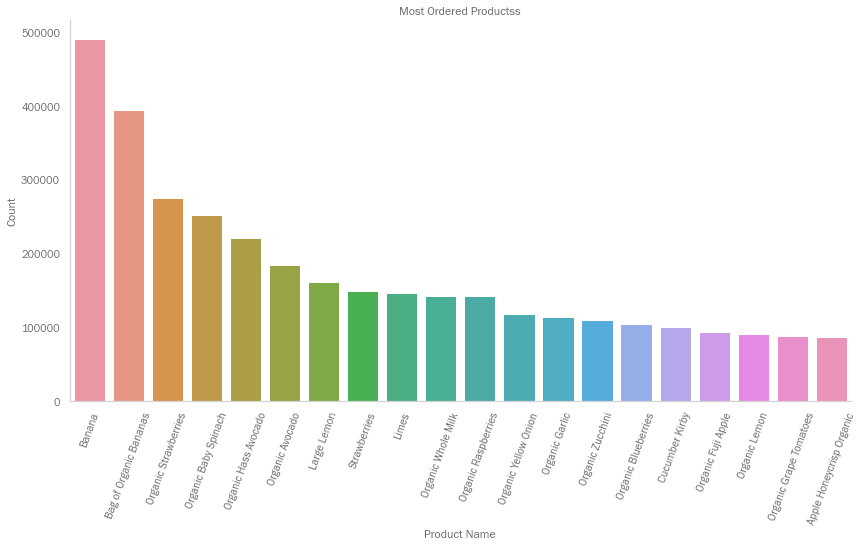

In [50]:
plt.figure(figsize = (14,7))
sns.countplot(x='product_name', data= order_products_desc, 
              order = order_products_desc.product_name.value_counts().index[:20])
plt.title('Most Ordered Productss')
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Product Name')
plt.savefig('Images/ordered_products_by_name.png');

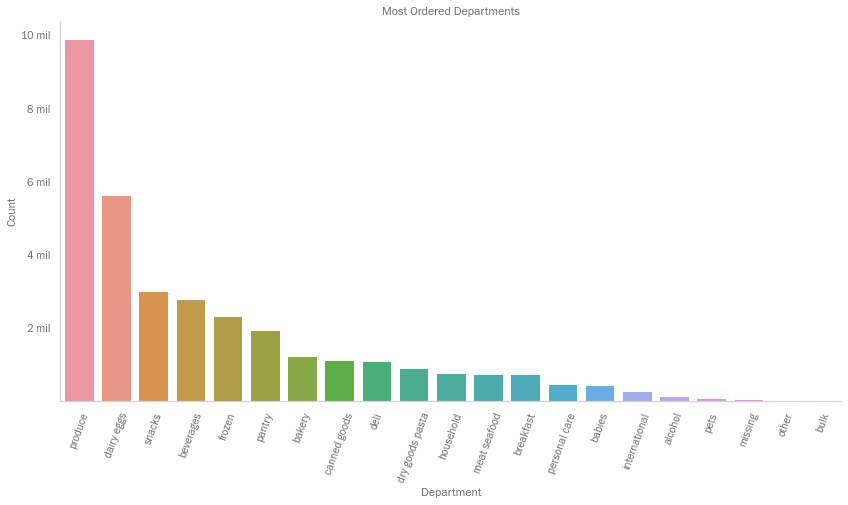

In [51]:
plt.figure(figsize = (14,7))
sns.countplot(x='department', data= order_products_desc, order = order_products_desc.department.value_counts().index)
plt.title('Most Ordered Departments')
plt.xticks(rotation=70)
plt.yticks([2000000,4000000,6000000,8000000,10000000],['2 mil','4 mil','6 mil','8 mil','10 mil'])
plt.ylabel('Count')
plt.xlabel('Department')
plt.savefig('Images/ordered_products_by_department.png');

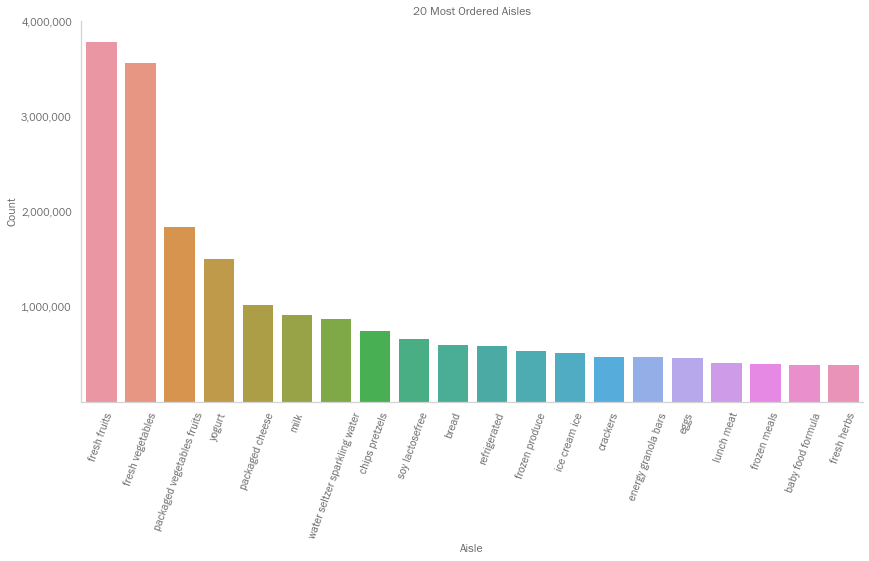

In [52]:
plt.figure(figsize = (14,7))
sns.countplot(x='aisle', data= order_products_desc, order = order_products_desc.aisle.value_counts().index[:20])
plt.title('20 Most Ordered Aisles')
plt.xticks(rotation=70)
plt.yticks([1000000,2000000,3000000,4000000],['1,000,000','2,000,000','3,000,000','4,000,000'])
plt.ylabel('Count')
plt.xlabel('Aisle')
plt.savefig('Images/ordered_products_by_aisle.png');

## Analyze user orders

Output: merged_orders

In [53]:
# Now merge the orders with the ordered prodcuts, combining on order_id
# This is a lot of info. We will trim some out before modeling.
merged_orders = pd.merge(orders, order_products_desc, on = 'order_id')
merged_orders.head() # Because the products showing are from the 1st order for this user, they all have Nan in days_since
# Because pd.merge defaults to an inner join, the test orders are not in this dataframe because they had no products.

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages
1,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,popcorn jerky,snacks
2,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree,dairy eggs
3,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods,household
4,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,popcorn jerky,snacks


In [54]:
len(merged_orders)

33819106

In [55]:
merged_orders[merged_orders['user_id']==3] # We see 12 orders, 88 products, no test order

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
296,1374495,3,prior,1,1,14,NaN,39190,5,0,Vanilla Unsweetened Almond Milk,91,16,soy lactosefree,dairy eggs
297,1374495,3,prior,1,1,14,NaN,16797,4,0,Strawberries,24,4,fresh fruits,produce
298,1374495,3,prior,1,1,14,NaN,9387,1,0,Granny Smith Apples,24,4,fresh fruits,produce
299,1374495,3,prior,1,1,14,NaN,21903,7,0,Organic Baby Spinach,123,4,packaged vegetables fruits,produce
300,1374495,3,prior,1,1,14,NaN,39922,8,0,Celery Sticks,123,4,packaged vegetables fruits,produce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,1402502,3,prior,12,1,15,15.0,18599,2,1,Garlic Couscous,4,9,instant foods,dry goods pasta
380,1402502,3,prior,12,1,15,15.0,21903,4,1,Organic Baby Spinach,123,4,packaged vegetables fruits,produce
381,1402502,3,prior,12,1,15,15.0,47766,5,1,Organic Avocado,24,4,fresh fruits,produce
382,1402502,3,prior,12,1,15,15.0,24810,6,1,Organic Lightly Salted Brown Rice Cakes,78,19,crackers,snacks


In [56]:
orders[orders['user_id']==3]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
26,1374495,3,prior,1,1,14,NaN
27,444309,3,prior,2,3,19,9.0
28,3002854,3,prior,3,3,16,21.0
29,2037211,3,prior,4,2,18,20.0
30,2710558,3,prior,5,0,17,12.0
31,1972919,3,prior,6,0,16,7.0
32,1839752,3,prior,7,0,15,7.0
33,3225766,3,prior,8,0,17,7.0
34,3160850,3,prior,9,0,16,7.0
35,676467,3,prior,10,3,16,17.0


In [57]:
# Creating the test set of orders
test = orders[orders['eval_set']=='test']
test.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [58]:
# Now I can see everything a particular user has ordered, and how often
merged_orders[merged_orders['user_id']==3]['product_name'].value_counts()

Vanilla Unsweetened Almond Milk                    10
Organic Avocado                                     9
Organic Baby Spinach                                8
Granny Smith Apples                                 5
Unsweetened Chocolate Almond Breeze Almond Milk     5
Garlic Couscous                                     4
Organic Peeled Whole Baby Carrots                   4
Strawberries                                        3
Organic Whole String Cheese                         3
Crackers, Crispy, Cheddar                           3
Organic Lightly Salted Brown Rice Cakes             3
All Natural No Stir Creamy Almond Butter            3
Green Beans                                         2
Wheat Gluten Free Waffles                           2
Electrolyte Water                                   2
Brussels Sprouts                                    2
Original Rotisserie Chicken                         2
Birthday Cake Light Ice Cream                       2
Chocolate Ice Cream         

In [59]:
# Here is every time this user ordered Organic Avocado
merged_orders[(merged_orders['user_id']==3) & (merged_orders['product_name']=='Organic Avocado')]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
301,1374495,3,prior,1,1,14,NaN,47766,6,0,Organic Avocado,24,4,fresh fruits,produce
318,3002854,3,prior,3,3,16,21.0,47766,2,1,Organic Avocado,24,4,fresh fruits,produce
331,2710558,3,prior,5,0,17,12.0,47766,4,1,Organic Avocado,24,4,fresh fruits,produce
341,1972919,3,prior,6,0,16,7.0,47766,4,1,Organic Avocado,24,4,fresh fruits,produce
359,3225766,3,prior,8,0,17,7.0,47766,6,1,Organic Avocado,24,4,fresh fruits,produce
365,3160850,3,prior,9,0,16,7.0,47766,2,1,Organic Avocado,24,4,fresh fruits,produce
369,676467,3,prior,10,3,16,17.0,47766,3,1,Organic Avocado,24,4,fresh fruits,produce
376,521107,3,prior,11,0,18,11.0,47766,2,1,Organic Avocado,24,4,fresh fruits,produce
381,1402502,3,prior,12,1,15,15.0,47766,5,1,Organic Avocado,24,4,fresh fruits,produce


## Clustering

In [61]:
# Now I want to experiment with clustering the 'similar' users together
# But what data do I need for each user?  Some kind of summary statistics?
# I guess I need each product to be a column, with the number of times it was ordered?
# Product level is too granular so I am going to try aisle

In [62]:
merged_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages
1,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,popcorn jerky,snacks
2,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree,dairy eggs
3,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods,household
4,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,popcorn jerky,snacks


In [63]:
# What don't I need for my user dataframe?
# Since product level is too granular, I will capture the aisle
user_info = merged_orders[['user_id', 'order_number', 'order_dow', 'order_hour_of_day', 
                           'days_since_prior_order', 'aisle_id']]

In [64]:
user_info.head()

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id
0,1,1,2,8,NaN,77
1,1,1,2,8,NaN,23
2,1,1,2,8,NaN,91
3,1,1,2,8,NaN,54
4,1,1,2,8,NaN,23


In [65]:
user_data = pd.get_dummies(user_info, prefix=None, columns=['aisle_id'])

In [66]:
user_data
# Group By User_id
# I need max of order_number
# Mode of order_dow, median of order_hour_of_day, mean of days_since
# Sum of each aisle

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id_1,aisle_id_2,aisle_id_3,aisle_id_4,aisle_id_5,...,aisle_id_125,aisle_id_126,aisle_id_127,aisle_id_128,aisle_id_129,aisle_id_130,aisle_id_131,aisle_id_132,aisle_id_133,aisle_id_134
0,1,1,2,8,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2,8,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,2,8,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,2,8,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,2,8,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33819101,206209,14,6,14,30.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33819102,206209,14,6,14,30.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33819103,206209,14,6,14,30.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33819104,206209,14,6,14,30.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
user_data['aisle_id_1'].value_counts()

0    33744242
1       74864
Name: aisle_id_1, dtype: int64

In [68]:
# Splitting the data in thirds to use groupby then will rejoin them
user_data1 = user_data[user_data['user_id'] <= 65000]
user_data2 = user_data[(user_data['user_id'] <= 135000) & (user_data['user_id'] > 65000)]
user_data3 = user_data[user_data['user_id'] > 135000]

In [69]:
grouped_user1 = user_data1.groupby('user_id').sum()

In [70]:
grouped_user2 = user_data2.groupby('user_id').sum()

In [71]:
grouped_user3 = user_data3.groupby('user_id').sum()

In [78]:
# Go back to user_data and drop the aisle info before I group the other variables in different ways
user_data1_noaisles = user_data1.iloc[:,:5]
user_data2_noaisles = user_data2.iloc[:,:5]
user_data3_noaisles = user_data3.iloc[:,:5]

In [88]:
# Cool.  Found a way to group each varaiable differently.
group1 = user_data1_noaisles.groupby('user_id').agg({'order_number': 'max', 'order_dow': lambda x:x.value_counts().index[0], 
                                            'order_hour_of_day': 'median', 'days_since_prior_order': 'mean'})
group2 = user_data2_noaisles.groupby('user_id').agg({'order_number': 'max', 'order_dow': lambda x:x.value_counts().index[0], 
                                            'order_hour_of_day': 'median', 'days_since_prior_order': 'mean'})
group3 = user_data3_noaisles.groupby('user_id').agg({'order_number': 'max', 'order_dow': lambda x:x.value_counts().index[0], 
                                            'order_hour_of_day': 'median', 'days_since_prior_order': 'mean'})

In [89]:
group1

,order_number,order_dow,order_hour_of_day,days_since_prior_order
user_id,,,,
1,11,4,8.0,19.200000
2,15,1,10.0,18.009390
3,12,0,16.0,11.487179
4,5,4,13.0,15.357143
5,5,0,16.0,12.314286
...,...,...,...,...
64996,15,2,14.0,17.057143
64997,5,0,11.0,20.869048
64998,4,5,10.0,24.521739


In [90]:
# get number of orders for each user and add to grouped_user dfs
grouped_user1['num_orders'] = group1.order_number
grouped_user2['num_orders'] = group2.order_number
grouped_user3['num_orders'] = group3.order_number

In [91]:
grouped_user1['mean_days_since'] = group1.days_since_prior_order
grouped_user2['mean_days_since'] = group2.days_since_prior_order
grouped_user3['mean_days_since'] = group3.days_since_prior_order

In [92]:
grouped_user1['mode_order_dow'] = group1.order_dow
grouped_user2['mode_order_dow'] = group2.order_dow
grouped_user3['mode_order_dow'] = group3.order_dow

In [93]:
grouped_user1['median_order_hour'] = group1.order_hour_of_day
grouped_user2['median_order_hour'] = group2.order_hour_of_day
grouped_user3['median_order_hour'] = group3.order_hour_of_day

In [96]:
grouped_user1.drop(columns=['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], inplace=True)
grouped_user2.drop(columns=['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], inplace=True)
grouped_user3.drop(columns=['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], inplace=True)

In [100]:
grouped_users = pd.concat([grouped_user1, grouped_user2, grouped_user3], axis=0)

In [101]:
grouped_users

,aisle_id_1,aisle_id_2,aisle_id_3,aisle_id_4,aisle_id_5,aisle_id_6,aisle_id_7,aisle_id_8,aisle_id_9,aisle_id_10,...,aisle_id_129,aisle_id_130,aisle_id_131,aisle_id_132,aisle_id_133,aisle_id_134,num_orders,mean_days_since,mode_order_dow,median_order_hour
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11,19.200000,4,8.0
2,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,15,18.009390,1,10.0
3,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12,11.487179,0,16.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,5,15.357143,4,13.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5,12.314286,0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4,14.705882,1,16.0
206206,0.0,3.0,7.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,67,4.042705,0,18.0
206207,0.0,0.0,6.0,0.0,0.0,0.0,2.0,0.0,6.0,0.0,...,0.0,3.0,1.0,0.0,0.0,0.0,16,14.879397,1,12.0


In [102]:
# This function came from a Medium article by Adam Ross Nelson to rearrange columns in a df
def movecol(df, cols_to_move=[], ref_col='', place='After'):
    
    cols = df.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df[seg1 + seg2 + seg3])

In [104]:
grouped_users = movecol(grouped_users, 
             cols_to_move=['num_orders', 'mode_order_dow', 'median_order_hour', 'mean_days_since'], 
             ref_col='aisle_id_1',
             place='Before')
grouped_users

,num_orders,mode_order_dow,median_order_hour,mean_days_since,aisle_id_1,aisle_id_2,aisle_id_3,aisle_id_4,aisle_id_5,aisle_id_6,...,aisle_id_125,aisle_id_126,aisle_id_127,aisle_id_128,aisle_id_129,aisle_id_130,aisle_id_131,aisle_id_132,aisle_id_133,aisle_id_134
user_id,,,,,,,,,,,,,,,,,,,,,
1,11,4,8.0,19.200000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15,1,10.0,18.009390,2.0,0.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12,0,16.0,11.487179,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,4,13.0,15.357143,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,5,0,16.0,12.314286,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,4,1,16.0,14.705882,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206206,67,0,18.0,4.042705,0.0,3.0,7.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
206207,16,1,12.0,14.879397,0.0,0.0,6.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2.0,0.0,3.0,1.0,0.0,0.0,0.0


In [ ]:
# I may be ready to cluster!!!  Might need to reset the index... I'll check. Don't think so!

In [105]:
from sklearn.cluster import KMeans
K_means = KMeans(n_clusters = 5)
K_means.fit(grouped_users)
cluster_assignments = K_means.predict(grouped_users)

In [107]:
len(cluster_assignments)

206209

In [116]:
# Is having 12 separate market segments helpful?  Can I figure out what make them different and target that?  

k_means_13 = KMeans(n_clusters=13).fit(grouped_users)
k_means_14 = KMeans(n_clusters=14).fit(grouped_users)
k_means_15 = KMeans(n_clusters=15).fit(grouped_users)
k_means_16 = KMeans(n_clusters=16).fit(grouped_users)
k_means_17 = KMeans(n_clusters=17).fit(grouped_users)
k_means_18 = KMeans(n_clusters=18).fit(grouped_users)
k_means_19 = KMeans(n_clusters=19).fit(grouped_users)
k_means_10 = KMeans(n_clusters=10).fit(grouped_users)
k_means_11 = KMeans(n_clusters=11).fit(grouped_users)
k_means_12 = KMeans(n_clusters=12).fit(grouped_users)
k_means_20 = KMeans(n_clusters=20).fit(grouped_users)

k_list = [k_means_10, k_means_11, k_means_12, k_means_13, 
          k_means_14, k_means_15, k_means_16, k_means_17, k_means_18, k_means_19, k_means_20]

In [117]:
from sklearn.metrics import calinski_harabasz_score

In [118]:
CH_score = []

for model in k_list:
    labels = model.labels_
    CH_score.append(calinski_harabasz_score(grouped_users, labels))

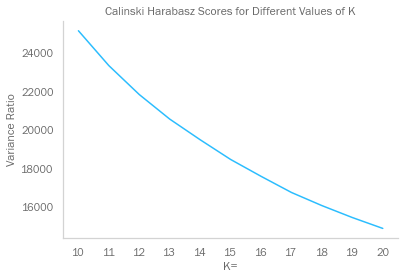

In [119]:
plt.plot([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], CH_score)
plt.xticks([10,11,12,13,14,15,16,17,18,19,20])
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.savefig('Images/ch_scores.png');

In [120]:
wcss_score = []

for model in k_list:
    labels = model.labels_
    wcss_score.append(model.inertia_)

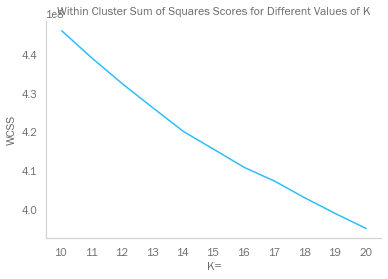

In [121]:
plt.plot([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], wcss_score)
plt.xticks([10,11,12,13,14,15,16,17,18,19,20])
plt.title('Within Cluster Sum of Squares Scores for Different Values of K')
plt.ylabel('WCSS')
plt.xlabel('K=')
plt.savefig('Images/wcss_scores.png');

In [122]:
# Ok I didn't scale the data, not that anything is way off.  Let's see if it matters.

In [124]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_users = scaler.fit_transform(grouped_users)

In [125]:
scaled_users

array([[-0.31368362,  0.63094204, -1.98290635, ..., -0.11252278,
        -0.15218975, -0.07028324],
       [-0.07361924, -0.75026401, -1.26590407, ..., -0.11252278,
        -0.15218975, -0.07028324],
       [-0.25366752, -1.21066602,  0.88510277, ..., -0.11252278,
        -0.15218975, -0.07028324],
       ...,
       [-0.01360315, -0.75026401, -0.54890179, ..., -0.11252278,
        -0.15218975, -0.07028324],
       [ 1.96692792, -0.28986199,  0.16810049, ..., -0.11252278,
        -0.15218975, -0.07028324],
       [-0.13363534, -0.75026401, -0.54890179, ..., -0.11252278,
        -0.15218975, -0.07028324]])

In [126]:
k_means_13 = KMeans(n_clusters=13).fit(scaled_users)
k_means_14 = KMeans(n_clusters=14).fit(scaled_users)
k_means_15 = KMeans(n_clusters=15).fit(scaled_users)
k_means_16 = KMeans(n_clusters=16).fit(scaled_users)
k_means_17 = KMeans(n_clusters=17).fit(scaled_users)
k_means_18 = KMeans(n_clusters=18).fit(scaled_users)
k_means_19 = KMeans(n_clusters=19).fit(scaled_users)
k_means_10 = KMeans(n_clusters=10).fit(scaled_users)
k_means_11 = KMeans(n_clusters=11).fit(scaled_users)
k_means_12 = KMeans(n_clusters=12).fit(scaled_users)
k_means_20 = KMeans(n_clusters=20).fit(scaled_users)

k_list = [k_means_10, k_means_11, k_means_12, k_means_13, 
          k_means_14, k_means_15, k_means_16, k_means_17, k_means_18, k_means_19, k_means_20]

In [127]:
CH_score = []

for model in k_list:
    labels = model.labels_
    CH_score.append(calinski_harabasz_score(grouped_users, labels))

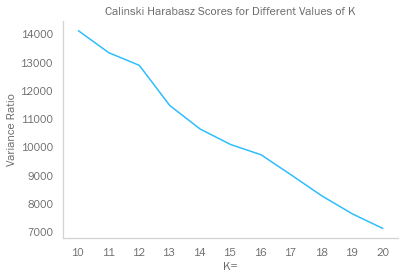

In [128]:
plt.plot([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], CH_score)
plt.xticks([10,11,12,13,14,15,16,17,18,19,20])
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.savefig('Images/ch_scaled_scores.png');

In [69]:
# user_data.groupby('user_id').count()

# Can't use groupby on a sparse matrix

from sqlalchemy import create_engine

engine = create_engine('sqlite:///grocery.db', echo=True)

In [70]:
user_data.to_sql('users', con=engine, if_exists='replace')

2021-02-09 17:58:13,407 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2021-02-09 17:58:13,410 INFO sqlalchemy.engine.base.Engine ()
2021-02-09 17:58:13,411 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2021-02-09 17:58:13,412 INFO sqlalchemy.engine.base.Engine ()
2021-02-09 17:58:13,415 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("users")
2021-02-09 17:58:13,416 INFO sqlalchemy.engine.base.Engine ()
2021-02-09 17:58:13,422 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("users")
2021-02-09 17:58:13,423 INFO sqlalchemy.engine.base.Engine ()
2021-02-09 17:58:13,425 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2021-02-09 17:58:13,426 INFO sqlalchemy.engine.base.Engine ()
2021-02-09 17:58:13,428 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_xinfo("users")
2021-02-09 17:58:13,428 INFO sqlalchemy.engine.base.Eng

MemoryError: Unable to allocate 258. MiB for an array with shape (33819106,) and data type object

In [ ]:
result = engine.execute('SELECT * from users;')
pd.DataFrame(result.fetchall(), columns = result.keys())

## Modeling

## Interpret Results / Conclusions

In [ ]:
pd.DataFrame([Philly_metrics, Indy_metrics, Daytona_metrics, Columbus_metrics, KC_metrics, Chattanooga_metrics])

In [ ]:
def final_ROI(dfs, forecasts):
    comparison = pd.DataFrame(index=['Zip Code','median housing price','actual 2018 ROI', 'forecast 2018 ROI'])
    for i, df in enumerate(dfs):
        metrics = [df['RegionName'][0], df.iloc[0,-1], round(100*df['recent_1_yr_ROI'][0],2), 
                   round(100*calc_forecast_ROI(forecasts[i]),2)]
        comparison[df['City'][0]] = metrics        
    return comparison

ROI_comparison = final_ROI(original_dfs, forecast_dfs)
ROI_comparison

Results: 

* All training data outperformed the test data.
* The models are all very skewed because of the market crash in 2009.
* Columbus and Daytona had very large confidence intervals and overly high forecasts.
* Chattanooga has outperformed even the confidence intervals of the model.
* Philadelphia is potentially a good 50K investment , Indianapolis at 75K and Chattanooga at 100K investment

Caveats: 
* Logged and differenced the data but some still did not test as stationary according to the Dickey Fuller test.
* Real estate predictions can vary due to unseen fluctuations in the market

Next Steps/Future Work: 
* Obtain current data after 2018 for current predictions. Found zip data on Redfin but it is rolling avg by zip code.
* Investigate why some of the models seem so far off in their forecasts.
